# Descriptive and Exploratory Questions

In [1]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import urllib2

url = ('https://raw.githubusercontent.com/Upward-Spiral-Science'
       '/data/master/syn-density/output.csv')
data = urllib2.urlopen(url)
csv = np.genfromtxt(data, delimiter=",")[1:] # don't want first row (labels)
print csv.shape

(61776, 5)


### Descriptive

- *What is the total number of synapses in our data set?*

In [2]:
print np.sum(csv[:,-1])

7704178.0


- *What does a histogram of synaptic density look like?*

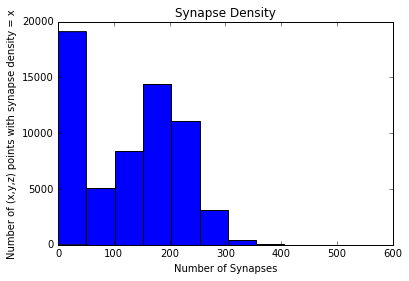

In [3]:
# Histogram
fig = plt.figure()
ax = fig.gca()
plt.hist(csv[:,4])
ax.set_title('Synapse Density')
ax.set_xlabel('Number of Synapses')
ax.set_ylabel('Number of (x,y,z) points with synapse density = x')
plt.show()

- *What is the unmasking variable?*
In the readme for our dataset, jovo writes: "i believe "masked" regions are regions that were "masked" by some computer vision mask that hides things that we know should not be neurons." So unmasked regions should, in general, have more synapses. Let's test this by looking at the correlation between the two.

In [4]:
corr = np.corrcoef(csv[:,3],csv[:,4])
print corr

[[ 1.          0.89621769]
 [ 0.89621769  1.        ]]


- *How clustered are the groups of synapses?*

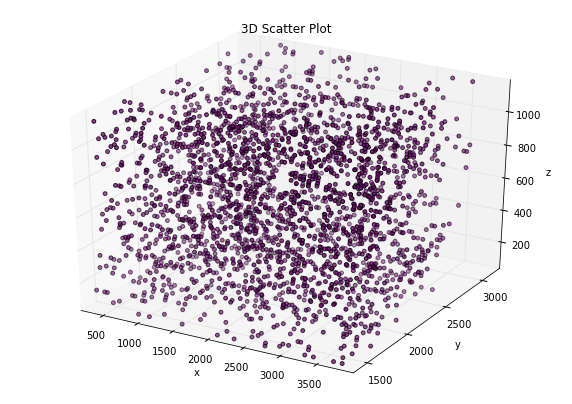

In [5]:
# this is a pretty broad question, but if we plot a random sample of data points where synapses exists,
# we can get a vague idea of how they're structured, we can furthermore restrict which data poitns get sampled
# by only taking ones where the number of synapses is greater than the average

samples = 2500 # how many samples to draw
def check_condition(row):
    if row[-1] == 0:
        return False
    return True

def synapse_filt(row, avg):
    if row[-1] > avg:
        return True
    return False

a = np.apply_along_axis(check_condition, 1, csv)
a = np.where(a == True)[0]
nonzero_rows = csv[a, :]

avg_synapse = np.mean(nonzero_rows[:, -1])
filter_avg_synapse = np.apply_along_axis(synapse_filt, 1,
                                         nonzero_rows, avg_synapse)
a = np.where(filter_avg_synapse == True)[0]
nonzero_filtered = nonzero_rows[a, :]
xyz_only = nonzero_filtered[:, [0, 1, 2]]

# randomly sample
perm = np.random.permutation(xrange(1, len(xyz_only[:])))
xyz_only = xyz_only[perm[:samples]]

# get range for graphing
mins = [np.amin(xyz_only[:, i]) for i in xrange(3)]
maxs = [np.amax(xyz_only[:, i]) for i in xrange(3)]

# following code adopted from
# https://www.getdatajoy.com/examples/python-plots/3d-scatter-plot
fig = plt.figure(figsize=(10, 7))
ax = fig.gca(projection='3d')

ax.set_title('3D Scatter Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim(mins[0], maxs[0])
ax.set_ylim(mins[1], maxs[1])
ax.set_zlim(mins[2], maxs[2])

ax.view_init()
ax.dist = 10  # distance

ax.scatter(
           xyz_only[:, 0], xyz_only[:, 1], xyz_only[:, 2],  # data
           c='purple',  # marker colour
           marker='o',  # marker shape
           s=15  # marker size
)

plt.show()

- *How are inhibitory and excitatory classes differentiated?*
In the 2011 paper by Bock et. al. they discuss this, but we believe more data is needed for us to be able to answer this.

### Exploratory

- *How can the data be clustered? (which metrics should be used for clustering?)*
- *What are the centers of such clusters*?
'How can the data be clustered?' is, again, a  pretty broad question. For now, we will use k-means and try a few different k-values. In terms of which metrics to be using, since we're dealing with objects in 3D space, Euclidean distance is the obvious choice.

[[ 3329.93315508  2055.77540107   623.94919786]
 [  886.62068966  2144.5          638.70689655]
 [ 2178.37748344  2643.25827815   685.71523179]
 [ 2060.95412844  1760.00183486   617.33211009]]


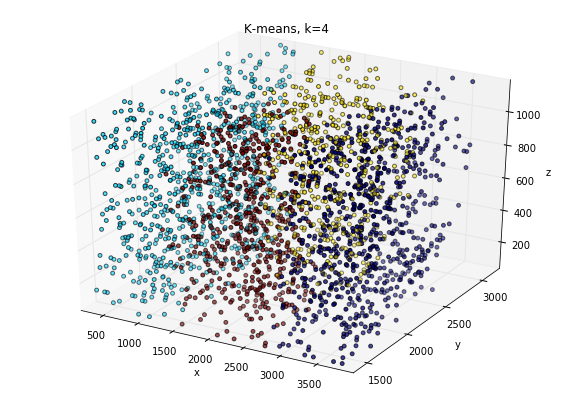

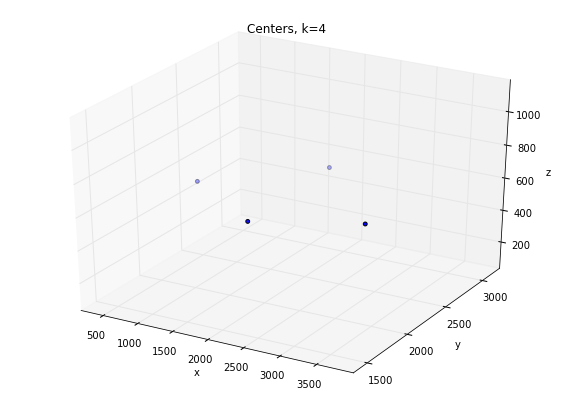

In [6]:
# run k-means on the data filtered like it was previously (only rows where synapses are greater than average)
# doing this to speed up computation time and to limit the number of data points that we will randomly sample 
# from when we graph the clusters

import sklearn.cluster as cluster

def graph_cluster(xyz_only, clusters, centers, k):
    # randomly sample
    samples = 2500
    perm = np.random.permutation(xrange(1, len(xyz_only[:])))
    xyz_only = xyz_only[perm[:samples]]
    clusters = clusters[perm[:samples]]

    # get range for graphing
    mins = [np.amin(xyz_only[:, i]) for i in xrange(3)]
    maxs = [np.amax(xyz_only[:, i]) for i in xrange(3)]

    # following code adopted from
    # https://www.getdatajoy.com/examples/python-plots/3d-scatter-plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')

    ax.set_title('K-means, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
               xyz_only[:, 0], xyz_only[:, 1], xyz_only[:, 2],  # data
               c=clusters,  # marker colour
               marker='o',  # marker shape
               s=15  # marker size
    )

    plt.show()
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.gca(projection='3d')
    ax.set_title('Centers, k='+str(k))
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    ax.set_xlim(mins[0], maxs[0])
    ax.set_ylim(mins[1], maxs[1])
    ax.set_zlim(mins[2], maxs[2])

    ax.view_init()
    ax.dist = 10  # distance

    ax.scatter(
           centers[:, 0], centers[:, 1], centers[:, 2],  # data
           c='blue',  # marker colour
           marker='o',  # marker shape
           s=15  # marker size
    )
    plt.show()

n_clusters = 4
kmeans_algo = cluster.KMeans(n_clusters=n_clusters)
clusters = kmeans_algo.fit_predict(xyz_only)
centers = kmeans_algo.cluster_centers_
print centers
graph_cluster(xyz_only, clusters, centers, n_clusters)

[[ 2069.07029877  1813.62741652   622.09490334]
 [ 3403.66990291  1835.48543689   634.78640777]
 [  817.96855346  1847.46540881   618.61006289]
 [ 2841.08559499  2587.20041754   625.52609603]
 [ 1278.44565217  2638.11086957   695.18043478]]


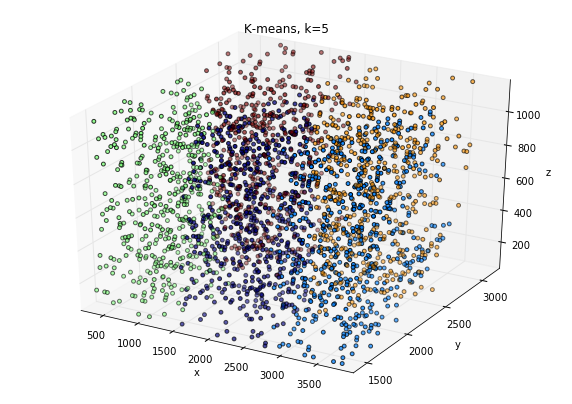

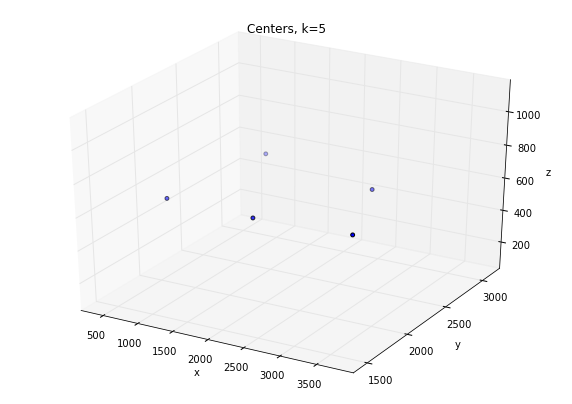

In [7]:
n_clusters = 5
kmeans_algo = cluster.KMeans(n_clusters=n_clusters)
clusters = kmeans_algo.fit_predict(xyz_only)
centers = kmeans_algo.cluster_centers_
print centers
graph_cluster(xyz_only, clusters, centers, n_clusters)

[[  707.08917197  1782.10191083   604.69745223]
 [ 2380.94883721  1742.31162791   947.64651163]
 [ 2506.58506224  2661.17842324   628.88381743]
 [ 3381.43243243  2372.67027027   290.2       ]
 [  809.93181818  2600.89772727   651.625     ]
 [ 2502.05676856  1825.75982533   286.20960699]
 [ 3309.10638298  2464.52659574   950.67553191]
 [ 1552.96072508  1806.12990937   589.87915408]
 [ 3489.43065693  1655.37956204   684.54014599]
 [ 1647.51351351  2615.19305019   762.14285714]]


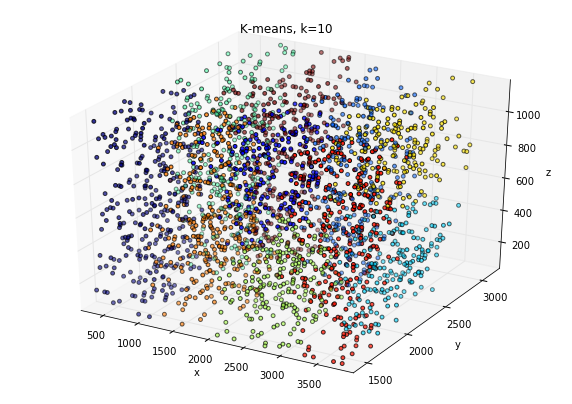

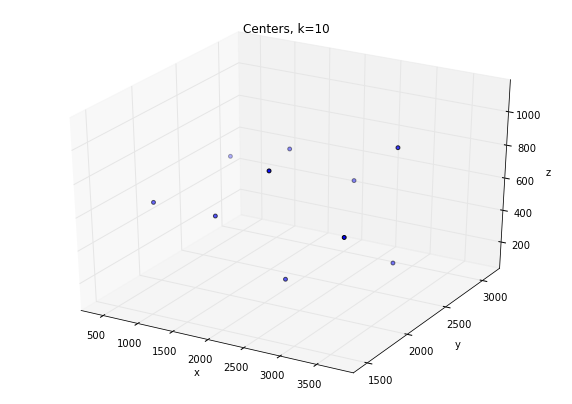

In [8]:
n_clusters = 10
kmeans_algo = cluster.KMeans(n_clusters=n_clusters)
clusters = kmeans_algo.fit_predict(xyz_only)
centers = kmeans_algo.cluster_centers_
print centers
graph_cluster(xyz_only, clusters, centers, n_clusters)

- *What is the mean of the probability mass function (recall our definition from last assignment: There is a probability mass function f: R^3→[0, 1] where f(x, y, z)=probability that a synapse exists at (x, y, z))? What is the covariance?*

In [9]:
# PMF
syns = csv[:,4]
sum = np.sum(syns)
density = syns/sum
mean = np.mean(density)
print mean
# get rid of unmasked column
no_unmasked = csv[:, [0, 1, 2, 4]]
# python crashes when trying to get covariance matrix (line below)
# print np.cov(no_unmasked)

1.61875161875e-05


- *What are the minimum and maximum x, y, and z values? (and thus, the set of (x,y,z) for our data set?*

In [10]:
print [min(csv[:,1]),min(csv[:,2]),min(csv[:,3])] #(x,y,z) minimum
print [max(csv[:,1]),max(csv[:,2]),max(csv[:,3])] #(x,y,z) maximum

[1369.0, 55.0, 0.0]
[3358.0, 1165.0, 165789.0]


- *Where does the maximum number of synapses occur (and what is the max number)?*

In [11]:
# Max number of synapses
max_syn = np.argmax(nonzero_rows[:,4])
print max_syn
loc = (nonzero_rows[max_syn,0],nonzero_rows[max_syn,1],nonzero_rows[max_syn,2]);
print loc

33450
(2749.0, 1876.0, 1054.0)
